### 作業目的: 實作word2vec Skip-gram模型
在課程中了解如何搭建CBOW模型，這次的作業目的在於透過搭建Skip-gram模型來了解另外一種word2vec的架構。

Hint_1: 學員可以善用課程中以搭建好的function模組
Hint_2: Skip_gram所需的輸入資料與目標跟CBOW有些許不同，Skip_gram是由中間字詞預測上下文

In [1]:
# import modules
import numpy as np
from typing import List
from utils.utility import clip_grads, convert_one_hot, preprocess, Trainer
from utils.layers import Dense, SoftmaxWithCrossEntropy
from utils.optimizer import SGD

In [2]:
# use the same corpus as in the lecture
text = "I am studying Natural Language Processing now."

# transform corpus to contexts and targets pair
corpus, word2idx, idx2word = preprocess([text])
corpus, word2idx, idx2word

(array([[6, 4, 0, 1, 5, 7, 3, 2]]),
 {'studying': 0,
  'natural': 1,
  '.': 2,
  'now': 3,
  'am': 4,
  'language': 5,
  'i': 6,
  'processing': 7},
 {0: 'studying',
  1: 'natural',
  2: '.',
  3: 'now',
  4: 'am',
  5: 'language',
  6: 'i',
  7: 'processing'})

In [3]:
# define create_contexts_target function
def create_contexts_target(corpus: List, window_size: int=1):
    
    contexts = []
    targets = []
    for i, idx in enumerate(corpus[window_size:-window_size], start=window_size):
        contexts.append(idx)
        pre = list(corpus[i-window_size:i])
        post = list(corpus[i+1:i+window_size+1])
        targets.append(pre+post)

    return np.array(contexts), np.array(targets)

contexts, targets= create_contexts_target(corpus[0], window_size=1)
contexts, targets

(array([4, 0, 1, 5, 7, 3]),
 array([[6, 0],
        [4, 1],
        [0, 5],
        [1, 7],
        [5, 3],
        [7, 2]]))

In [4]:
# transform contexts and targets to one-hot encoding
contexts = convert_one_hot(contexts, len(word2idx))
targets = convert_one_hot(targets, len(word2idx))
contexts, targets

(array([[0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0]]),
 array([[[0, 0, 0, 0, 0, 0, 1, 0],
         [1, 0, 0, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 1, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0]],
 
        [[1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0]],
 
        [[0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1]],
 
        [[0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 1, 0, 0, 0, 0, 0]]]))

In [13]:
# define Skip-gram model
class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size):
        V, H = vocab_size, hidden_size
        self.window_size = window_size

        # initialize weights
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # create layers
        self.in_layer = Dense(W_in)
        self.out_layer = Dense(W_out)
        self.loss_layer = [SoftmaxWithCrossEntropy() for i in range(self.window_size*2)]
        

        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # word vector matrix
        self.word_vecs = W_in

    def forward(self, contexts, targets):
        h = self.in_layer.forward(contexts)
        s = self.out_layer.forward(h)
        
        loss = sum([self.loss_layer[i].forward(s, targets[:, i]) for i in range(self.window_size*2)])
        return loss

    def backward(self, dout=1):
        
        ds = sum([self.loss_layer[i].backward(dout) for i in range(self.window_size*2)]) 
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        
        return None

In [14]:
# start training

# configurations
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

# define model
skip_gram = SkipGram(len(word2idx), hidden_size, window_size)
sgd_optimizer = SGD()
trainer = Trainer(skip_gram, sgd_optimizer)

# start training
trainer.fit(contexts, targets, max_epoch, batch_size)

 11%|████████▍                                                                    | 110/1000 [00:00<00:00, 1099.23it/s]

Epoch: 1, Iteration: 1/2, Loss: 4.158765248316547
Epoch: 2, Iteration: 1/2, Loss: 4.158832344611928
Epoch: 3, Iteration: 1/2, Loss: 4.158676004350825
Epoch: 4, Iteration: 1/2, Loss: 4.1587360466939485
Epoch: 5, Iteration: 1/2, Loss: 4.158583424880192
Epoch: 6, Iteration: 1/2, Loss: 4.158660664714541
Epoch: 7, Iteration: 1/2, Loss: 4.158504742460407
Epoch: 8, Iteration: 1/2, Loss: 4.158472011718142
Epoch: 9, Iteration: 1/2, Loss: 4.158543447666597
Epoch: 10, Iteration: 1/2, Loss: 4.15838623435536
Epoch: 11, Iteration: 1/2, Loss: 4.158324969606671
Epoch: 12, Iteration: 1/2, Loss: 4.158265445306498
Epoch: 13, Iteration: 1/2, Loss: 4.157975819526989
Epoch: 14, Iteration: 1/2, Loss: 4.158097028658086
Epoch: 15, Iteration: 1/2, Loss: 4.158074134107924
Epoch: 16, Iteration: 1/2, Loss: 4.157883721273583
Epoch: 17, Iteration: 1/2, Loss: 4.157744772643391
Epoch: 18, Iteration: 1/2, Loss: 4.15797181027895
Epoch: 19, Iteration: 1/2, Loss: 4.1576352370193455
Epoch: 20, Iteration: 1/2, Loss: 4.15771

 34%|██████████████████████████▍                                                  | 343/1000 [00:00<00:00, 1147.19it/s]

Epoch: 199, Iteration: 1/2, Loss: 1.4592312090098218
Epoch: 200, Iteration: 1/2, Loss: 1.4606754375684785
Epoch: 201, Iteration: 1/2, Loss: 1.4625970012628704
Epoch: 202, Iteration: 1/2, Loss: 1.4584397043173243
Epoch: 203, Iteration: 1/2, Loss: 1.463629156745451
Epoch: 204, Iteration: 1/2, Loss: 1.4559345461485307
Epoch: 205, Iteration: 1/2, Loss: 1.447981729042557
Epoch: 206, Iteration: 1/2, Loss: 1.453975270116426
Epoch: 207, Iteration: 1/2, Loss: 1.4538292242904196
Epoch: 208, Iteration: 1/2, Loss: 1.4523654529333643
Epoch: 209, Iteration: 1/2, Loss: 1.44679509647849
Epoch: 210, Iteration: 1/2, Loss: 1.455718756339344
Epoch: 211, Iteration: 1/2, Loss: 1.4575394540494653
Epoch: 212, Iteration: 1/2, Loss: 1.4345059869699717
Epoch: 213, Iteration: 1/2, Loss: 1.450480833003505
Epoch: 214, Iteration: 1/2, Loss: 1.4521910381892322
Epoch: 215, Iteration: 1/2, Loss: 1.4466255162969985
Epoch: 216, Iteration: 1/2, Loss: 1.4545935668887782
Epoch: 217, Iteration: 1/2, Loss: 1.4299619009753726


 58%|████████████████████████████████████████████▌                                | 579/1000 [00:00<00:00, 1161.24it/s]


Epoch: 418, Iteration: 1/2, Loss: 1.3994203048922271
Epoch: 419, Iteration: 1/2, Loss: 1.4015928340424282
Epoch: 420, Iteration: 1/2, Loss: 1.3995375468633453
Epoch: 421, Iteration: 1/2, Loss: 1.4009874907048991
Epoch: 422, Iteration: 1/2, Loss: 1.4008342028977574
Epoch: 423, Iteration: 1/2, Loss: 1.4002347405270628
Epoch: 424, Iteration: 1/2, Loss: 1.4007970546817996
Epoch: 425, Iteration: 1/2, Loss: 1.399507566333389
Epoch: 426, Iteration: 1/2, Loss: 1.3997692288298493
Epoch: 427, Iteration: 1/2, Loss: 1.4000117716108322
Epoch: 428, Iteration: 1/2, Loss: 1.4011363355684625
Epoch: 429, Iteration: 1/2, Loss: 1.3976572495157837
Epoch: 430, Iteration: 1/2, Loss: 1.400908910471443
Epoch: 431, Iteration: 1/2, Loss: 1.3986773902577792
Epoch: 432, Iteration: 1/2, Loss: 1.3997411177494579
Epoch: 433, Iteration: 1/2, Loss: 1.401065518044351
Epoch: 434, Iteration: 1/2, Loss: 1.399343442324968
Epoch: 435, Iteration: 1/2, Loss: 1.4004337247644978
Epoch: 436, Iteration: 1/2, Loss: 1.3986658317279

 81%|██████████████████████████████████████████████████████████████▌              | 813/1000 [00:00<00:00, 1159.61it/s]

Epoch: 635, Iteration: 1/2, Loss: 1.3936258203117082
Epoch: 636, Iteration: 1/2, Loss: 1.3929603642563326
Epoch: 637, Iteration: 1/2, Loss: 1.3934665032253304
Epoch: 638, Iteration: 1/2, Loss: 1.3943563196347073
Epoch: 639, Iteration: 1/2, Loss: 1.3930434486573406
Epoch: 640, Iteration: 1/2, Loss: 1.3930222735978905
Epoch: 641, Iteration: 1/2, Loss: 1.3938009814867827
Epoch: 642, Iteration: 1/2, Loss: 1.3933747642199892
Epoch: 643, Iteration: 1/2, Loss: 1.3929683111089972
Epoch: 644, Iteration: 1/2, Loss: 1.3938647676740654
Epoch: 645, Iteration: 1/2, Loss: 1.3932079823571848
Epoch: 646, Iteration: 1/2, Loss: 1.39293396516516
Epoch: 647, Iteration: 1/2, Loss: 1.3936715350458861
Epoch: 648, Iteration: 1/2, Loss: 1.393658242914547
Epoch: 649, Iteration: 1/2, Loss: 1.3928942829550341
Epoch: 650, Iteration: 1/2, Loss: 1.3927409259213315
Epoch: 651, Iteration: 1/2, Loss: 1.3933671717560014
Epoch: 652, Iteration: 1/2, Loss: 1.3935854472022244
Epoch: 653, Iteration: 1/2, Loss: 1.3932065471766

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1154.64it/s]

Epoch: 854, Iteration: 1/2, Loss: 1.390562360651544
Epoch: 855, Iteration: 1/2, Loss: 1.3910221903351478
Epoch: 856, Iteration: 1/2, Loss: 1.3909479489246315
Epoch: 857, Iteration: 1/2, Loss: 1.3911799907392286
Epoch: 858, Iteration: 1/2, Loss: 1.3910238879377377
Epoch: 859, Iteration: 1/2, Loss: 1.3906192716620858
Epoch: 860, Iteration: 1/2, Loss: 1.3909043473497182
Epoch: 861, Iteration: 1/2, Loss: 1.3909098520061076
Epoch: 862, Iteration: 1/2, Loss: 1.3908229414994233
Epoch: 863, Iteration: 1/2, Loss: 1.390972801078443
Epoch: 864, Iteration: 1/2, Loss: 1.3908872585864478
Epoch: 865, Iteration: 1/2, Loss: 1.3905773669964328
Epoch: 866, Iteration: 1/2, Loss: 1.391251515794751
Epoch: 867, Iteration: 1/2, Loss: 1.391009607888198
Epoch: 868, Iteration: 1/2, Loss: 1.3903998178935515
Epoch: 869, Iteration: 1/2, Loss: 1.3908631597180228
Epoch: 870, Iteration: 1/2, Loss: 1.3913632176371507
Epoch: 871, Iteration: 1/2, Loss: 1.3907573930554076
Epoch: 872, Iteration: 1/2, Loss: 1.39068390375209

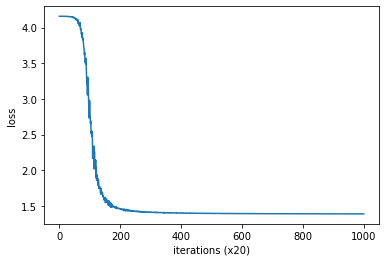

In [15]:
trainer.plot()

In [16]:
# check skip-gram results
wordvec = skip_gram.word_vecs

for word, idx in word2idx.items():
    print(word, wordvec[idx])

studying [ 2.3076906   0.790949   -1.01499     0.78101444  0.8062162 ]
natural [-1.1617371 -2.2114336  1.0420225  1.3365339 -0.7364704]
. [-0.02836574  0.00716158  0.02342706  0.00366387  0.01242384]
now [-1.4463122   1.0570209   0.9299893  -1.988174   -0.09864694]
am [ 0.6009513  -0.03649484  1.2671524   0.8690332  -2.3610373 ]
language [ 1.1078458   1.5574567  -0.7132943  -2.11905     0.82170826]
i [-0.01361924  0.0080411   0.00972695 -0.0208737   0.01263655]
processing [-1.3577284 -1.5144658 -1.1657577  0.6523272  1.4017758]
